In [39]:
!fc-list

/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf: Liberation Sans Narrow:style=Italic
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: Liberation Sans:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf: Liberation Mono:style=Bold Italic
/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf: Liberation Serif:style=Italic
/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf: Liberation Mono:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/liberation/Libe

In [40]:
# 실행 런타임(CPU/GPU) 확인후 설치, 세션 초기화되면 재설치, GPU
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [41]:
import os
os.getcwd()

'/content/drive/MyDrive/kd_ml/cnn/colab_green/test'

In [42]:
# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
from google.colab import drive
drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import cv2

import numpy as np
import pandas as pd
import seaborn as sb

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/colab_green' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [44]:
width = 128
height = 128

# 주어진 폴더의 모든 파일을 numpy array로 변환하는 함수
def convertArray(path):
    file_list = os.listdir(path)
    img_X = [] # data
    img_Y = [] # target
    
    for i in range(len(file_list)):
        spt = os.path.splitext(file_list[i])
        # print(spt) # ('0', '.jpg')
        img_Y.append(int(spt[0])) # 파일명
        
#         img = Image.open(path + "/" + file_list[i])
#         img_array = np.array(img)
        image_bgr = cv2.imread(path + "/" + file_list[i], cv2.IMREAD_COLOR)
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        # 1차원 list안에 3차원 배열로 변경된 이미지를 저장     
        img_X.append(image_rgb) 

    img_X = np.array(img_X) # 이미지 데이터 [] -> ndarray
    img_Y = np.array(img_Y) # Target, Y

    
    # OpenCV는 흰색을 255로 나타냄으로 변환이 필요함.
    img_X = 255 - img_X # 색이 없으면 0으로 인식되게 변환, 255 - 4차원 배열
    
    # 텐서플로와 GPU 미분 기반에 최적화되어 있어
    # 0 ~ 1 사이의 실수 값으로 변경하면 정확도 상승, 정규화
    img_X = img_X / 255.0
    print('img_X: ', img_X.shape);
    
    # img_Y.reshape(img_Y.shape[0], 1): target은 2차원 배열의 형태이어야함.
    # 행수는 이미지 수, 컬럼이 1개인 2차원 배열
    # astype(int): 찾아야하는 값은 정수이기 때문에 형변환
    return img_X, img_Y.reshape(img_Y.shape[0], 1).astype(int)

In [45]:
# 데이터 준비
x_train, y_train = convertArray('./train') # 훈련용
x_val, y_val = convertArray('./val')       # 검증용
x_test, y_test = convertArray('./test')    # 테스트용 
# (70, 128, 128, 3): 칼라 이미지 70장, (count, width, height, color channel)

img_X:  (70, 128, 128, 3)
img_X:  (18, 128, 128, 3)
img_X:  (5, 128, 128, 3)


In [46]:
print(x_train.shape) 
print(y_train.shape) # (67, 1), 녹초 수치, 정수형

print(x_val.shape)   # 검증데이터
print(y_val.shape)   

print(x_test.shape)  # 테스트 데이터
print(y_test.shape) 
print(y_test)

(70, 128, 128, 3)
(70, 1)
(18, 128, 128, 3)
(18, 1)
(5, 128, 128, 3)
(5, 1)
[[200]
 [150]
 [100]
 [ 50]
 [ 47]]


In [47]:
print(type(x_train[0, 0, 0, 0])) # 첫번째 이미지 첫번째 픽셀의 type 확인
print(x_train[0:1]) # 첫번째 이미지 배열 값

<class 'numpy.float64'>
[[[[1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   ...
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]]

  [[1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   ...
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]]

  [[1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   ...
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]]

  ...

  [[1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   ...
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]
   [1.         0.         0.99607843]]

  [[1.         0.    

In [48]:
print(y_train[0:10]) # 훈련 target 확인

[[255]
 [245]
 [235]
 [225]
 [215]
 [205]
 [190]
 [170]
 [140]
 [120]]


In [49]:
width=128
height=128

tf.random.set_seed(0)
model = Sequential()
# 128: 128 개의 2차원 특징맵이 생성됨, 필터(커널)의 수.
# kernel_size = (3, 3): 필터 크기는 3행 3열의 난수기반 행렬이 생성됨.
# padding='same': 차원 축소를 방지, 외곽에 0을 추가 
# input_shape = (width, height, 3): 칼라 입력 이미지, 흑백: 1
# model.add(Conv2D(64, kernel_size = (3, 3), padding='same',
#                  input_shape = (width, height, 3), activation='relu'))

model.add(Conv2D(128, kernel_size = (3, 3), padding='same',
                 input_shape = (width, height, 3), activation='relu'))
# (None, 128, 128, 128)     3584: 128 x 128 이미지, 128 channel
# 3584: 필터_size * 필터 갯수 * color 수 + Bias 수
#       9 * 128 * 3 + 128  

# 특성맵이 128 -> 32개로 감소
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))

# 4개중에 최대값 1개만 다음 레이어로 전달, 특징만 추출
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음, 파라미터 감소.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(1)) # 활성화 함수 생략시 수치 예측(회귀 산출)
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 128)     3584      
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      36896     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                  

In [50]:
# mcp = ModelCheckpoint(filepath='./Iris.h5', monitor='val_accuracy',
#                       verbose=1, save_best_only=True)

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
                 shuffle=True, epochs=1000, 
                 batch_size=1, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# patience=20
# i5 2320: 313초 i5 8500 6core: 160 초
# gtx 1060: 30 초, Colab: 21.40 초

Epoch 1/1000
70/70 [==============================] - 2s 20ms/step - loss: 10900.7178 - val_loss: 206.5585
Epoch 2/1000
70/70 [==============================] - 1s 17ms/step - loss: 260.2491 - val_loss: 64.5936
Epoch 3/1000
70/70 [==============================] - 1s 16ms/step - loss: 73.3821 - val_loss: 167.8489
Epoch 4/1000
70/70 [==============================] - 1s 16ms/step - loss: 7.7916 - val_loss: 5.4545
Epoch 5/1000
70/70 [==============================] - 1s 17ms/step - loss: 7.3030 - val_loss: 5.5454
Epoch 6/1000
70/70 [==============================] - 1s 17ms/step - loss: 3.8976 - val_loss: 6.1568
Epoch 7/1000
70/70 [==============================] - 1s 16ms/step - loss: 1.9107 - val_loss: 6.7334
Epoch 8/1000
70/70 [==============================] - 1s 16ms/step - loss: 1.9456 - val_loss: 5.4979
Epoch 9/1000
70/70 [==============================] - 1s 16ms/step - loss: 6.3546 - val_loss: 8.7454
Runtime: 11.69 초


### Local에서는 너무 느려서 검증과 테스트를 진행하지 않음

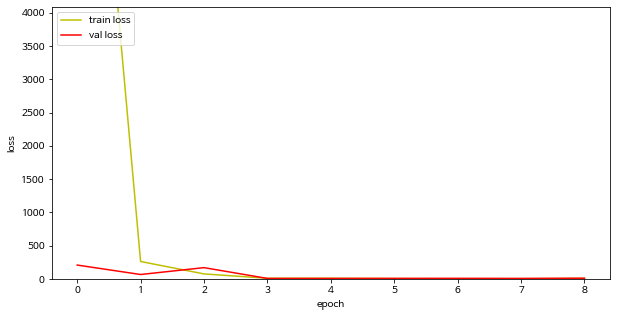

In [51]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

# acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 4087.1168]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
# acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
# acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
# acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
# acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [52]:
yp = model.predict(x_test, batch_size=1) # 모델 사용
print(yp)

[[200.84727 ]
 [150.91765 ]
 [ 99.92204 ]
 [ 50.87385 ]
 [ 47.332638]]


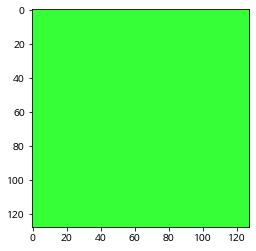

In [53]:
# 테스트할 첫번째 이미지 확인
file_list = os.listdir('./test')
img_bgr = cv2.imread('./test' + "/" + file_list[0], cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

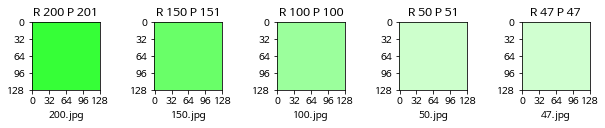

In [54]:
import glob # 파일 필터링

# fig.set_size_inches(16, 5)  # 챠트 크기 설정 
plt.rcParams["figure.figsize"] = (10, 4) # subplot 크기 결정
fig = plt.figure() # rows*cols 행렬의 i번째 subplot 생성
fig.tight_layout() # 최적의 간격 설정
rows = 1           # 1행 4열 이미지 출력
cols = 5
i = 1

# left - 왼쪽 margin. 디폴트는 0.125
# right - 오른쪽 margin. 디폴트는 0.9
# bottom - 아래쪽 margin. 디폴트는 0.1
# top - 위쪽 margin. 디폴트는 0.9
# wspace - subplots 의 수평 간격. 디폴트는 0.2
# hspace - subplots 의 수직 간격. 디폴트는 0.2
plt.subplots_adjust(wspace=0.8, hspace=0.4)

# 디렉터리 위치 변경
os.chdir('./test') 

for filename in glob.glob("*.jpg"): # jpg 파일만 추출
    img_bgr = cv2.imread(filename, cv2.IMREAD_COLOR)
    ax = fig.add_subplot(rows, cols, i) # 1, 5, 1
    ax.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # BGR -> RGB
    # R: 실제값, P: 예측한 값, yp: 예측값, 배열 index: i-1
    ax.set_title('R {0:.0f} P {1:.0f}'.format(y_test[i-1][0], yp[i-1][0]))
    ax.set_xlabel(filename)
    ax.set_xticks([0, 32, 64, 96, 128]) # x축 눈금선 
    ax.set_yticks([0, 32, 64, 96, 128])
    i += 1 # 서브플롯 갯수 증가

plt.show()
os.chdir(path) # 기본 경로로 변경